In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

In [2]:
from langchain.globals import set_llm_cache
from langchain.cache import SQLiteCache

set_llm_cache(SQLiteCache(database_path=".collaborative-agents.llm.db"))

In [3]:
from llm_agents_introduction.alpha_vantage import AlphaVantageService
from langchain_openai import ChatOpenAI

alpha_vantage = AlphaVantageService.create()

gpt_4o = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [4]:
from typing import Optional, TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    company_symbol: str
    company_name: str
    trend: str
    latest_report: Optional[str]
    latest_review: Optional[str]
    analyst_messages: Annotated[list[BaseMessage], add_messages]
    editor_messages: Annotated[list[BaseMessage], add_messages]

In [5]:
initial_state = State(
    company_name='Microsoft',
    company_symbol='MSFT',
    trend='Why did the share price jump up so much between Oct 2023 and Dec 2023?'
)

In [6]:
from datetime import date
from uuid import uuid4
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from langchain_openai import OpenAIEmbeddings
from llm_agents_introduction.news_clustering import cluster_news_links


# mocked database for storing clustered headline results
researcher_datastore = {}


# Model for keeping track of a topic (group of related headlines)
# and an id for using for storing all the related urls in the "database"
class HeadlineTopic(BaseModel):
    """
    The research will group together related headlines under a topic and summarize the headline.
    To get further details on a topic provide the topic_id to the ResearchHeadlineTopic tool
    """
    topic_id: str = Field(description="A unique identifier for the topic")
    summary: str = Field(description="A summary of the headlines for the topic (will be limited in detail)")
    article_count: int = Field(description="The number of distinct articles we found on this topic")


class SearchHeadlines(BaseModel):
    """
    Will look through news headlines regarding the company to find distinct topics related to your description.
    Ask the Summarizer to for the full details of each topic.
    """
    from_date: str = Field(description="The date from which to fetch headlines in YYYY-MM-DD format")
    to_date: str = Field(description="The date to which to fetch headlines in YYYY-MM-DD format")
    description: str = Field(description="Describe what type of headlines you are looking for. The researcher already knows your looking into the company's stock price.")
    limit: int = Field(description="How many headlines to return", default=20)



class ResearchHeadlineTopic(BaseModel):
    """
    Will do deep research on a topic found by the researcher and return a summary of the topic with source references.
    To ask for further details on a topic, provide the same topic_id and a specify what you want to know in the request field.
    """
    topic_id: str = Field(description="The topic_id previously returned to you for a group of headlines related to a topic.")
    request: str = Field(description="Is there any thing specific you want to know about the topic? If not, just leave empty.")


embeddings_model = OpenAIEmbeddings(model='text-embedding-3-large')


topic_summary_from_headlines_chain = (
    RunnablePassthrough.assign(
        combined_headlines=lambda state: "\n".join([ f' - {headline}' for headline in state['headlines'] ]),
    )
    | ChatPromptTemplate.from_messages([
        (
            "system", 
            "Your task is to create a single summary from a set of related headlines regarding the company \"{company_name}\" on a topic. " +
            "Give a very succinct summary of the topic. Only use the content of the headlines - do not guess what it may be about." +
            "Do not say your are summarizing headlines - just give the summary of the topic like a headline itself."
        ),
        (
            "human",
            "Please create a summary of the following headlines:\n{combined_headlines}"
        )
    ])
    | gpt_4o
    | StrOutputParser()
)


def search_headlines(company_symbol: str, company_name: str, request: SearchHeadlines) -> list[HeadlineTopic]:
    headlines = alpha_vantage.fetch_relevant_news(
        company_symbol,
        from_date=date.fromisoformat(request.from_date),
        to_date=date.fromisoformat(request.to_date),
    )
    print(f'Found {len(headlines)} news articles')
    clustered_headlines = cluster_news_links(headlines, embeddings_model)
    print(f'Clustered into {len(clustered_headlines)} topics')

    clustered_headlines = clustered_headlines[:request.limit]
    headline_summaries = topic_summary_from_headlines_chain.batch(
        [
            # take at most 20 headlines for each cluster
            { "headlines": [ news_link.title for news_link in cluster[:20] ], "company_name": company_name }
            for cluster in clustered_headlines
        ]
    )
    
    results = []

    # store each set of clustered headlines we return so the research can fetch the urls
    for headlines, summary in zip(clustered_headlines, headline_summaries):
        id = str(uuid4())
        researcher_datastore[id] = headlines
        results.append(HeadlineTopic(topic_id=id, summary=summary, article_count=len(headlines)))

    return results


topics = search_headlines('MSFT', 'Microsoft', SearchHeadlines(from_date='2023-10-01', to_date='2023-12-31', description='stock price'))

topics

Found 711 news articles
Clustered into 89 topics


[HeadlineTopic(topic_id='adbfb590-0d80-4069-a144-e143ad8e5c23', summary="Microsoft's stock is being closely evaluated for its potential growth, particularly due to advancements in artificial intelligence, which analysts believe could be a significant catalyst for the company.", article_count=26),
 HeadlineTopic(topic_id='813829d8-3047-4807-a4ea-06fd61b4f093', summary='Microsoft is frequently compared to other tech stocks and is considered a strong investment option in various contexts, including AI, growth, and income.', article_count=23),
 HeadlineTopic(topic_id='a9a9018d-d95e-4419-83bd-e55b0d331c97', summary="Nvidia's stock has surged dramatically in 2023, driven by its leadership in AI and semiconductor technology, making it a standout performer and significantly boosting CEO Jensen Huang's wealth. The company continues to innovate with China-specific chips despite US restrictions, while the broader semiconductor and AI sectors are expected to remain strong in 2024.", article_count=

In [7]:
from llm_agents_introduction.alpha_vantage import NewsLink
from langchain_core.runnables import RunnableLambda
from urllib.parse import urlparse

content_cache = {}

class PickArticlesToReview(BaseModel):
    """
    List of articles you would like to fetch to summarize.
    """
    article_indexes: list[int] = Field(description="List of articles from the provided list that you would like to review. Cannot pick more than 5 at once.")


def create_article_list(news_links: list[NewsLink]) -> str:
    return "\n".join(
        [ 
            f'{i+1}. {news_link.published_on.isoformat()}: {news_link.title} (published by: {urlparse(news_link.url).hostname})' 
            for i, news_link 
            in enumerate(news_links[:30]) # take a most 30
        ]
    )


pick_articles_chain = (
    RunnablePassthrough.assign(
        formatted_article_list=lambda state: create_article_list(state["news_links"]),
    )
    | ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a research assistant that is tasked with picking which articles to review help in answering the provided request. " + 
            "Use the PickArticlesToReview tool to select which articles you would suggest reviewing. " +
            "Select no more than 5 articles."
        ),
        (
            "human",
            "I want to research: \"{request}\"\n"
            + "Please pick articles to research from this list:\n{formatted_article_list}"
        )
    ])
    | gpt_4o.bind_tools(tools=[PickArticlesToReview], tool_choice=PickArticlesToReview.__name__)
    | RunnableLambda(lambda message: message.tool_calls[0]['args']['article_indexes'])
    # we put them in the prompt in a starting from 1, so 0 index them
    | RunnableLambda(lambda article_indexes: [ index - 1 for index in article_indexes ])
)

topic_news_links = researcher_datastore[topics[0].topic_id]

selected_article_indexes = pick_articles_chain.invoke({
    "request": "A generate overview of the topic",
    "news_links": researcher_datastore[topics[0].topic_id]
})

selected_news_links = [ topic_news_links[selected_index] for selected_index in selected_article_indexes ]

selected_news_links

[NewsLink(title="Artificial intelligence may be 'iPhone moment' for Microsoft in price target hike, analysts says", url='https://www.marketwatch.com/story/artificial-intelligence-may-be-iphone-moment-for-microsoft-in-price-target-hike-analysts-says-2869eb93', summary='Wedbush analyst says artificial intelligence will boost cloud business growth ...', overall_sentiment_score=0.250738, published_on=datetime.date(2023, 12, 28), ticker_sentiment=[TickerSentiment(ticker='MSFT', relevance_score=0.535653, ticker_sentiment_score=0.567824), TickerSentiment(ticker='GOOG', relevance_score=0.230235, ticker_sentiment_score=0.046121), TickerSentiment(ticker='AAPL', relevance_score=0.230235, ticker_sentiment_score=0.547466)]),
 NewsLink(title='Cathie Wood Is Buying Up These 2 Game-Changing Generative AI Stocks', url='https://www.fool.com/investing/2023/12/15/cathie-wood-buy-game-change-generative-ai-stock/', summary="These two AI giants are getting a bump in one of Ark Invest's biggest ETFs.", overal

In [8]:
from langchain_core.runnables import RunnableBranch
from llm_agents_introduction.article_summarization import extract_text_from_url, word_count

min_words = 100
max_words = 1000

def download_news_article(url: str) -> Optional[str]:
    body = extract_text_from_url(url)

    if not body:
        return None
    
    words = word_count(body)

    if words < min_words or words > max_words:
        return None
    
    return body


news_article_summarizer_system_prompt = """
You are a assistant who summarizes the content of a news article about a company.

Read the article and summarize the content into a concise, succinct short paragraph focusing on the main points and key facts.
""".strip()

news_article_summarizer_prompt = ChatPromptTemplate.from_messages([
    ("system", news_article_summarizer_system_prompt),
    ("human", "Please summarize this article into a short paragraph:\n{body}")
])

news_article_summarizer_chain = (
    news_article_summarizer_prompt
    | gpt_4o
    | StrOutputParser()
)

news_link_summarizer_chain = (
    {
        "news_link": RunnablePassthrough(),
    }
    | RunnablePassthrough.assign(
        body=lambda state: download_news_article(state["news_link"].url)
    )
    | RunnablePassthrough.assign(
        summary=RunnableBranch(
            (lambda state: state["body"] is not None, news_article_summarizer_chain),
            lambda _: None
        )
    )
)

news_article_summaries = news_link_summarizer_chain.batch(selected_news_links)
news_article_summaries

Downloading: https://www.marketwatch.com/story/artificial-intelligence-may-be-iphone-moment-for-microsoft-in-price-target-hike-analysts-says-2869eb93
Downloading: https://www.fool.com/investing/2023/12/15/cathie-wood-buy-game-change-generative-ai-stock/
Downloading: https://www.fool.com/investing/2023/12/23/artificial-intelligence-stocks-buy-and-hold-ai/
Downloading: https://www.cnbc.com/2023/12/27/pc-market-to-rebound-as-consumers-refresh-devices-seek-ai-features.html
Downloading: https://www.fool.com/investing/2023/12/22/3-big-pharma-stocks-are-making-big-plays-with-ai/
Extracting: https://www.cnbc.com/2023/12/27/pc-market-to-rebound-as-consumers-refresh-devices-seek-ai-features.html
Extracting: https://www.fool.com/investing/2023/12/23/artificial-intelligence-stocks-buy-and-hold-ai/
Extracting: https://www.fool.com/investing/2023/12/15/cathie-wood-buy-game-change-generative-ai-stock/
Extracting: https://www.fool.com/investing/2023/12/22/3-big-pharma-stocks-are-making-big-plays-with-

[{'news_link': NewsLink(title="Artificial intelligence may be 'iPhone moment' for Microsoft in price target hike, analysts says", url='https://www.marketwatch.com/story/artificial-intelligence-may-be-iphone-moment-for-microsoft-in-price-target-hike-analysts-says-2869eb93', summary='Wedbush analyst says artificial intelligence will boost cloud business growth ...', overall_sentiment_score=0.250738, published_on=datetime.date(2023, 12, 28), ticker_sentiment=[TickerSentiment(ticker='MSFT', relevance_score=0.535653, ticker_sentiment_score=0.567824), TickerSentiment(ticker='GOOG', relevance_score=0.230235, ticker_sentiment_score=0.046121), TickerSentiment(ticker='AAPL', relevance_score=0.230235, ticker_sentiment_score=0.547466)]),
  'body': None,
  'summary': None},
 {'news_link': NewsLink(title='Cathie Wood Is Buying Up These 2 Game-Changing Generative AI Stocks', url='https://www.fool.com/investing/2023/12/15/cathie-wood-buy-game-change-generative-ai-stock/', summary="These two AI giants 

In [9]:
from langchain_core.messages import HumanMessage, ToolMessage, ToolCall
from langchain_core.prompts import MessagesPlaceholder
from operator import or_
from pprint import pprint
import json

summarizer_system_prompt = """
You are a research assistant that is exclusively responsible for summarizing related news articles into a single concise summary.
Prioritize facts and key points, and avoid adding your own interpretation or opinion.
Make sure to include reference sources for each fact you include in the summary.
""".strip()

class SummarizeState(TypedDict):
    topic_id: str
    used_urls: Annotated[set[str], or_]
    messages: Annotated[list[BaseMessage], add_messages]


class SearchForArticles(BaseModel):
    """
    Will filter the set of available articles to only a subset that match the request, will download those articles and return a summary for each.
    """
    request: str = Field(description="Will be used to filter the headlines available")


def search_for_articles(state: SummarizeState):
    tool_call = state["messages"][-1].tool_calls[0]
    args = SearchForArticles(**tool_call["args"])

    news_links = researcher_datastore[state["topic_id"]]
    # filter out urls we've already reviewed
    news_links = [ news_link for news_link in news_links if news_link.url not in state["used_urls"] ]

    news_link_indexes_to_summarize = pick_articles_chain.invoke({
        "request": args.request,
        "news_links": news_links
    })

    selected_news_links = [ news_links[selected_index] for selected_index in news_link_indexes_to_summarize ]

    news_article_summaries = news_link_summarizer_chain.batch(selected_news_links)
    
    links_with_summaries = [ result for result in news_article_summaries if result['summary'] ]

    result: str

    if links_with_summaries:
        result_items = [
            { 'url': result['news_link'].url, 'summary': result['summary'] }
            for result in links_with_summaries
        ]
        result = json.dumps(result_items)
    else:
        result = "We found no summaries with that request"

    return {
        "messages": ToolMessage(tool_call_id=tool_call["id"], content=result),
        "used_urls": { news_link.url for news_link in selected_news_links }
    }



summarizer_chain = (
    ChatPromptTemplate.from_messages([
        ("system", summarizer_system_prompt),
        MessagesPlaceholder("messages")
    ]) 
    | gpt_4o.bind_tools(tools=[SearchForArticles], parallel_tool_calls=False)
    | {
        "messages": RunnablePassthrough()
    }
)


def summarizer(state: SummarizeState):
    return summarizer_chain.invoke(state)

def summarizer_router(state: SummarizeState):
    return "search_for_articles" if state["messages"][-1].tool_calls else END

summarizer_graph = StateGraph(SummarizeState)

summarizer_graph.add_node("summarizer", summarizer)
summarizer_graph.add_node("search_for_articles", search_for_articles)

summarizer_graph.set_entry_point("summarizer")
summarizer_graph.add_conditional_edges("summarizer", summarizer_router)
summarizer_graph.add_edge("search_for_articles", "summarizer")

summarizer_app = summarizer_graph.compile()

initial_state = {
    "topic_id": topics[0].topic_id,
    "used_urls": set(),
    "messages": [
        HumanMessage("Why did this improve the stock price?")
    ]
}

for update in summarizer_app.stream(initial_state):
    pprint(update)


{'summarizer': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_evnAdvOAupqNTigFDAf1xUTj', 'function': {'arguments': '{"request":"stock price increase reasons"}', 'name': 'SearchForArticles'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 135, 'total_tokens': 153}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d33f7b429e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a963a1ae-b6ca-4ac7-89d8-deef8bc10c0e-0', tool_calls=[{'name': 'SearchForArticles', 'args': {'request': 'stock price increase reasons'}, 'id': 'call_evnAdvOAupqNTigFDAf1xUTj'}], usage_metadata={'input_tokens': 135, 'output_tokens': 18, 'total_tokens': 153})}}
Downloading: https://www.cnbc.com/2023/12/27/pc-market-to-rebound-as-consumers-refresh-devices-seek-ai-features.html
Downloading: https://www.marketwatch.com/story/artificial-intelligence-may-be-iphone-moment-for-microsoft-in-price-target-hike-analysts-say

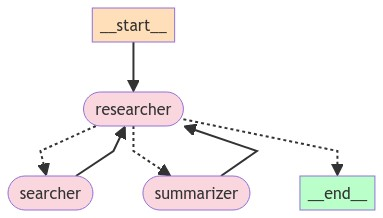

{'researcher': {'researcher_messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EggMIQT5kCUFnawttdUYNuEX', 'function': {'arguments': '{"from_date":"2023-09-01","to_date":"2023-10-01","description":"reasons for stock price increase","limit":5}', 'name': 'SearchHeadlines'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 354, 'total_tokens': 398}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d33f7b429e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-01dcdb13-029f-4bbe-b524-53481426e529-0', tool_calls=[{'name': 'SearchHeadlines', 'args': {'from_date': '2023-09-01', 'to_date': '2023-10-01', 'description': 'reasons for stock price increase', 'limit': 5}, 'id': 'call_EggMIQT5kCUFnawttdUYNuEX'}], usage_metadata={'input_tokens': 354, 'output_tokens': 44, 'total_tokens': 398})}}
Found 710 news articles
Clustered into 99 topics
{'searcher': {'researcher_messages': ToolMessage(content='[{"t

In [10]:
from collections import defaultdict
from langchain_core.messages import HumanMessage
from langchain_core.prompts import MessagesPlaceholder
from langgraph.graph import StateGraph
from pprint import pprint
from IPython.display import Image, display, Markdown

def add_topic_summary_messages(state, new_messages: dict[str, list[BaseMessage]]):
    if "summarizer_messages" not in state:
        state["summarizer_messages"] = defaultdict(list)
    
    for topic_id, messages in new_messages.items():
        state["summarizer_messages"][topic_id].extend(messages)
    
    return state


class ResearcherState(TypedDict):
    company_name: str
    company_symbol: str
    from_date: str
    to_date: str
    summarizer_messages: Annotated[dict[str, list[BaseMessage]], add_topic_summary_messages]
    researcher_messages: Annotated[list[BaseMessage], add_messages]
    

class SummarizeTopic(BaseModel):
    """
    Summarize a topic that was previously provided by the SearchHeadlines tool.
    Provided a request description if you're after something in particular.
    """
    topic_id: str = Field(description="The topic id previously provided by the SearchHeadlines tool")
    request_description: str = Field(description="If you need some details in particular supply this - otherwise just say general summary")


researcher_system_prompt = """
You are a research assistant that is tasked with researching news articles about a company ("{company_name}") to help answer the provided request.

There can be a very large number of distinct articles to review so you are provided with two tools:
1. SearchHeadlines - to find distinct topics from all available news articles for the period
2. SummarizeTopic - to get a detailed summary of a topic found by the SearchHeadlines tool

Focus providing a succinct answer to the question provided.
Make sure to provide references to the sources of your information.
Focus on facts and dates where possible to provider a clear and factual answer.
""".strip()

researcher_chain = (
    ChatPromptTemplate.from_messages([
        ("system", researcher_system_prompt),
        MessagesPlaceholder("researcher_messages"),
    ])
    | gpt_4o.bind_tools(tools=[SearchHeadlines, SummarizeTopic], parallel_tool_calls=False)
    | {
        "researcher_messages": RunnablePassthrough()
    }
)

def researcher(state: ResearcherState):
    return researcher_chain.invoke(state)

def research_router(state: ResearcherState) -> str:
    tool_calls: list[ToolCall] = state["researcher_messages"][-1].tool_calls

    if tool_calls:
        match tool_calls[0]['name']:
            case SearchHeadlines.__name__:
                return "searcher"
            case SummarizeTopic.__name__:
                return "summarizer"
    else:
        return END


def searcher(state: ResearcherState):
    tool_call = state["researcher_messages"][-1].tool_calls[-1]
    args = SearchHeadlines(**tool_call['args'])

    topics = search_headlines(state["company_symbol"], state["company_name"], args)
    serialized_result = json.dumps([ topic.dict() for topic in topics ])

    return { "researcher_messages": ToolMessage(tool_call_id=tool_call['id'], content=serialized_result) }

def summarize_topic(state: ResearcherState):
    tool_call = state["researcher_messages"][-1].tool_calls[-1]
    args = SummarizeTopic(**tool_call['args'])

    existing_topic_messages = state["summarizer_messages"].get(args.topic_id, [])

    summarizer_result = summarizer_app.invoke({
        "topic_id": args.topic_id,
        "messages": existing_topic_messages + [ HumanMessage(args.request_description) ]
    })

    researcher_response = summarizer_result["messages"][-1].content

    return {
        "researcher_messages": ToolMessage(tool_call_id=tool_call['id'], content=researcher_response),
        "summarizer_messages": { args.topic_id: summarizer_result["messages"] }
    }

    

graph = StateGraph(ResearcherState)

graph.add_node("researcher", researcher)
graph.add_node("searcher", searcher)
graph.add_node("summarizer", summarize_topic)

graph.set_entry_point("researcher")
graph.add_conditional_edges("researcher", research_router)
graph.add_edge("searcher", "researcher")
graph.add_edge("summarizer", "researcher")

researcher_app = graph.compile()
display(Image(researcher_app.get_graph(xray=True).draw_mermaid_png()))

initial_state = ResearcherState(
    company_name='Microsoft',
    company_symbol='MSFT',
    from_date='2023-10-01',
    to_date='2023-12-31',
    researcher_messages=[
        HumanMessage('Why did the stock price shoot up?')
    ]
)

for update in researcher_app.stream(initial_state):
    pprint(update)

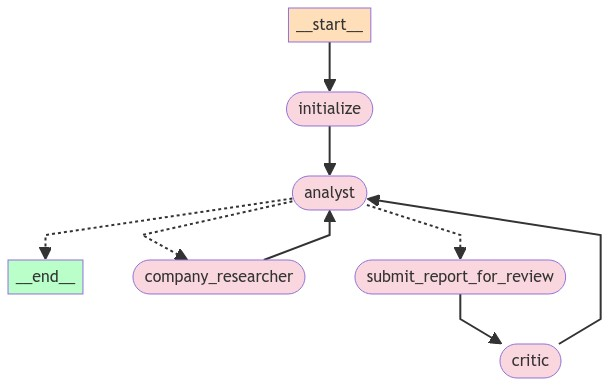

{'initialize': {'analyst_messages': HumanMessage(content='Please write a report on: Why did the Telsa (TSLA) share price dip so much then immediately recover')}}


# Report

Found 703 news articles
Clustered into 86 topics
Downloading: https://www.benzinga.com/analyst-ratings/analyst-color/23/10/35067332/teslas-q3-delivery-slip-sparks-analyst-concerns-is-ev-demand-waning
Downloading: https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/
Downloading: https://www.investors.com/news/tesla-stock-q3-deliveries-fell-as-wall-street-stays-focused-on-positives/
Downloading: https://www.forbes.com/sites/qai/2023/10/03/tesla-literally-fails-to-deliver-on-more-evs-sends-share-price-plummeting/
Downloading: https://www.reuters.com/business/autos-transportation/tesla-reports-fall-third-quarter-deliveries-misses-estimates-2023-10-02/
Extracting: https://www.forbes.com/sites/qai/2023/10/03/tesla-literally-fails-to-deliver-on-more-evs-sends-share-price-plummeting/
Extracting: https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/
Extracting: ht

# Report

# Tesla (TSLA) Share Price Dip and Recovery Analysis

## Overview

Tesla (TSLA) recently experienced a significant dip in its share price, followed by a swift recovery. This report delves into the reasons behind this volatility, focusing on key events, market reactions, and strategic moves by the company.

## Key Events

### Q3 2023 Deliveries and Production

- **Deliveries**: 435,059 vehicles
- **Production**: 430,488 vehicles
- Both figures were down from the previous quarter, primarily due to planned factory upgrades. These upgrades included scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan.

### Market Reaction

- The delivery shortfall led to a 2.11% drop in Tesla's stock price.
- Analysts expressed concerns about Tesla's pricing strategies, demand, and gross margins. For example:
  - **Truist Securities**: William Stein reiterated a Hold rating with a lowered price target.
  - **Bernstein**: Toni Sacconaghi maintained an Underperform rating.
  - **GLJ Research**: Gordon Johnson reiterated a Sell rating, citing significant demand issues.

### Strategic Moves

- Despite the challenges, Tesla maintained its full-year target of 1.8 million vehicles.
- The company reintroduced the rear-wheel-drive Model Y in the U.S. at a competitive price and prepared for new model launches to boost future sales.

### Valuation and Competition

- Tesla's high valuation at over 71x forward earnings and increasing competition, along with price cuts affecting margins, could limit near-term upside.
- Tesla's 2023 earnings are expected to decline year-over-year.

## Conclusion

The recent dip and subsequent recovery in Tesla's share price were primarily influenced by its Q3 2023 delivery numbers, which fell short of market expectations. The market reacted negatively to the shortfall, but strategic moves and future prospects helped the stock recover. Analysts remain divided on Tesla's future performance, highlighting the volatility and mixed sentiments surrounding the stock.

For more detailed information, you can refer to the sources: [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/23/10/35067332/teslas-q3-delivery-slip-sparks-analyst-concerns-is-ev-demand-waning), [Forbes](https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/).

{'submit_report_for_review': {'critic_messages': HumanMessage(content="# Tesla (TSLA) Share Price Dip and Recovery Analysis\n\n## Overview\n\nTesla (TSLA) recently experienced a significant dip in its share price, followed by a swift recovery. This report delves into the reasons behind this volatility, focusing on key events, market reactions, and strategic moves by the company.\n\n## Key Events\n\n### Q3 2023 Deliveries and Production\n\n- **Deliveries**: 435,059 vehicles\n- **Production**: 430,488 vehicles\n- Both figures were down from the previous quarter, primarily due to planned factory upgrades. These upgrades included scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan.\n\n### Market Reaction\n\n- The delivery shortfall led to a 2.11% drop in Tesla's stock price.\n- Analysts expressed concerns about Tesla's pricing strategies, demand, and gross margins. For example:\n  - **Truist Securi

# Editor Feedback

- **Title Consistency**: Ensure the title is consistent with the content. Consider renaming to "Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023" for clarity.
  
- **Introduction Clarity**: The introduction should briefly mention the time frame and context of the events discussed. Specify the exact period when the dip and recovery occurred.

- **Quantitative Data Context**: Provide context for the delivery and production numbers. Mention the previous quarter's figures for comparison to highlight the decline.

- **Market Reaction Details**: Clarify the timeline of the stock price drop and recovery. Specify the dates or time frame when the 2.11% drop occurred and when the recovery was observed.

- **Analyst Opinions**: Include the specific price targets and ratings from the analysts mentioned. For example, what was the lowered price target from Truist Securities?

- **Strategic Moves Explanation**: Elaborate on the significance of reintroducing the rear-wheel-drive Model Y and the expected impact of new model launches. Explain how these moves are expected to boost future sales.

- **Valuation and Competition**: Provide more details on the competition and how it specifically impacts Tesla. Mention key competitors and their market strategies.

- **Earnings Decline**: Quantify the expected decline in Tesla's 2023 earnings. Provide specific figures or percentages to give a clearer picture.

- **Conclusion Specificity**: The conclusion should summarize the key points more succinctly. Reiterate the main reasons for the share price volatility and the mixed analyst sentiments.

- **Source Integration**: Integrate the sources more seamlessly into the text. Instead of listing them at the end, reference them within the relevant sections to support specific points.

- **Grammar and Style**: Ensure consistent use of tense and style throughout the report. For example, "holding back production in China to launch an upgraded Model 3 sedan" should be "held back production in China to launch an upgraded Model 3 sedan."

- **Fact-Checking**: Verify all figures and statements for accuracy. Ensure that the data presented is up-to-date and correctly sourced.

# Report

Found 695 news articles
Clustered into 79 topics
Downloading: https://www.benzinga.com/news/23/08/34095795/why-tesla-stock-is-moving-higher-today
Downloading: https://www.benzinga.com/news/23/08/34116780/whats-going-on-with-tesla-stock
Downloading: https://www.zacks.com/stock/news/2141584/tesla-tsla-gains-but-lags-market-what-you-should-know
Downloading: https://www.benzinga.com/news/23/08/33969471/why-tesla-stock-is-higher-today
Downloading: https://www.investors.com/news/tesla-stock-flirts-with-buy-signal-as-these-factors-propel-investor-interest/
Extracting: https://www.benzinga.com/news/23/08/33969471/why-tesla-stock-is-higher-today
Extracting: https://www.benzinga.com/news/23/08/34116780/whats-going-on-with-tesla-stock
Extracting: https://www.benzinga.com/news/23/08/34095795/why-tesla-stock-is-moving-higher-today
Extracting: https://www.zacks.com/stock/news/2141584/tesla-tsla-gains-but-lags-market-what-you-should-know
Downloading: https://www.benzinga.com/analyst-ratings/analyst-c

# Report

# Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023

## Introduction

In Q3 2023, Tesla (TSLA) experienced significant share price volatility, marked by a notable dip followed by a swift recovery. This report examines the events and market reactions that contributed to this volatility, focusing on the period from early October 2023.

## Key Events

### Q3 2023 Deliveries and Production

- **Deliveries**: 435,059 vehicles
- **Production**: 430,488 vehicles
- **Comparison with Q2 2023**:
  - **Q2 Deliveries**: 466,140 vehicles
  - **Q2 Production**: 479,700 vehicles
- The decline in Q3 was attributed to planned factory upgrades, including scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan.

### Market Reaction

- **Stock Price Reaction**: Tesla's stock dropped by 2.11% following the Q3 delivery shortfall.
- **Timeline**: The dip occurred immediately after the release of the Q3 delivery numbers in early October 2023. The recovery was observed within the following week as the market digested the news and Tesla's strategic responses.

### Analyst Opinions

- **Truist Securities**: William Stein reiterated a Hold rating with a lowered price target of $243, citing concerns about pricing strategies, demand, and gross margins.
- **Bernstein**: Toni Sacconaghi maintained an Underperform rating, expressing worries about Tesla's demand and pricing strategies.
- **GLJ Research**: Gordon Johnson reiterated a Sell rating, citing significant demand issues and suggesting that Tesla's stock is overvalued given the expected decline in deliveries.

## Strategic Moves

- **Reintroduction of Rear-Wheel-Drive Model Y**: Tesla reintroduced the rear-wheel-drive Model Y in the U.S. at a competitive price, aiming to boost sales and attract cost-conscious consumers.
- **New Model Launches**: Tesla is preparing for the launch of the Cybertruck and an upgraded Model 3 sedan, which are expected to drive future sales and market interest.

## Valuation and Competition

### Competition

- **Rivian Automotive Inc.**:
  - **Q3 Deliveries**: 15,564 vehicles, closely trailing Tesla's 15,985 Model S and X deliveries.
  - **Product Line**: Rivian's R1T truck and R1S SUV compete directly with Tesla's premium offerings, the Model X and Model S.
  - **Market Position**: Rivian aims to post its first gross profit in 2024, emphasizing the importance of software, electronics, and vehicle performance integration.
- **Traditional Automakers**:
  - **General Motors (GM)**: Reported a 21% year-over-year increase in U.S. auto sales in Q3 2023.
  - **Toyota**: Saw a 12.2% increase in U.S. auto sales in the same period.
  - **Honda**: Experienced a significant 52.7% rise in U.S. auto sales.
- **Industry Challenges**:
  - **UAW Strike**: The ongoing United Auto Workers (UAW) strike poses potential cost challenges for traditional automakers, which could benefit Tesla by reducing competition from these manufacturers.

### Valuation

- Tesla's high valuation at over 71x forward earnings and increasing competition, along with price cuts affecting margins, could limit near-term upside.
- Despite maintaining its full-year target of 1.8 million vehicles, Tesla's 2023 earnings are expected to decline year-over-year.

## Expected Decline in 2023 Earnings

- Tesla's 2023 earnings are expected to decline year-over-year due to missed delivery estimates and planned factory upgrades.
- The stock is currently seen as relatively neutral with a price estimate of $263, which is 5% above the current market price.

## Conclusion

The recent dip and subsequent recovery in Tesla's share price were primarily influenced by its Q3 2023 delivery numbers, which fell short of market expectations. The market reacted negatively to the shortfall, but strategic moves and future prospects helped the stock recover. Analysts remain divided on Tesla's future performance, highlighting the volatility and mixed sentiments surrounding the stock.

### Sources

- [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/23/10/35067332/teslas-q3-delivery-slip-sparks-analyst-concerns-is-ev-demand-waning)
- [Forbes](https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/)
- [Benzinga](https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals)
- [Benzinga](https://www.benzinga.com/23/10/35089353/uaw-strike-overshadows-strong-q3-deliveries)

{'submit_report_for_review': {'critic_messages': HumanMessage(content="# Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023\n\n## Introduction\n\nIn Q3 2023, Tesla (TSLA) experienced significant share price volatility, marked by a notable dip followed by a swift recovery. This report examines the events and market reactions that contributed to this volatility, focusing on the period from early October 2023.\n\n## Key Events\n\n### Q3 2023 Deliveries and Production\n\n- **Deliveries**: 435,059 vehicles\n- **Production**: 430,488 vehicles\n- **Comparison with Q2 2023**:\n  - **Q2 Deliveries**: 466,140 vehicles\n  - **Q2 Production**: 479,700 vehicles\n- The decline in Q3 was attributed to planned factory upgrades, including scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan.\n\n### Market Reaction\n\n- **Stock Price Reaction**: Tesla's stock dropped by 2.11% following the Q3 delivery sho

# Editor Feedback

- **Introduction Specificity**: The introduction should specify the exact dates or time frame of the share price dip and recovery for clarity.

- **Key Events Section**: The "Q3 2023 Deliveries and Production" section should explicitly state the percentage decline from Q2 to Q3 to provide a clearer picture of the impact.

- **Market Reaction Details**: The "Stock Price Reaction" subsection should include the exact dates when the stock price dropped and recovered to provide a precise timeline.

- **Analyst Opinions**: Include the specific price targets and ratings from all analysts mentioned. For example, what is the price target from Bernstein and GLJ Research?

- **Strategic Moves Explanation**: Provide more context on how the reintroduction of the rear-wheel-drive Model Y and the launch of new models are expected to impact Tesla's market position and sales.

- **Competition Section**: The "Competition" subsection should be more concise. Focus on the most relevant competitors and their direct impact on Tesla. Remove less relevant details to maintain clarity and conciseness.

- **Valuation and Competition**: Separate the "Valuation" and "Competition" sections for better readability. Each section should have its own heading and content.

- **Expected Decline in 2023 Earnings**: Quantify the expected decline in earnings with specific figures or percentages. Provide more context on how the missed delivery estimates and factory upgrades are impacting earnings.

- **Conclusion Specificity**: The conclusion should summarize the key points more succinctly. Reiterate the main reasons for the share price volatility and the mixed analyst sentiments.

- **Source Integration**: Integrate the sources more seamlessly into the text. Instead of listing them at the end, reference them within the relevant sections to support specific points.

- **Grammar and Style**: Ensure consistent use of tense and style throughout the report. For example, "holding back production in China to launch an upgraded Model 3 sedan" should be "held back production in China to launch an upgraded Model 3 sedan."

- **Fact-Checking**: Verify all figures and statements for accuracy. Ensure that the data presented is up-to-date and correctly sourced.

- **Redundancy**: Avoid redundancy in the "Expected Decline in 2023 Earnings" section. The information about the stock being relatively neutral with a price estimate of $263 should be integrated into the valuation section.

- **Formatting**: Ensure consistent formatting of bullet points and subheadings for better readability.

# Report

Found 418 news articles
Clustered into 56 topics
Downloading: https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/
Downloading: https://www.investors.com/news/tesla-stock-q3-deliveries-fell-as-wall-street-stays-focused-on-positives/
Downloading: https://www.forbes.com/sites/qai/2023/10/03/tesla-literally-fails-to-deliver-on-more-evs-sends-share-price-plummeting/
Downloading: https://www.marketwatch.com/story/teslas-stock-falls-as-a-long-time-bear-sees-the-falling-profit-outlook-as-a-bigger-problem-than-weak-deliveries-1303c661
Downloading: https://www.marketwatch.com/story/teslas-stock-drops-after-deliveries-data-missed-lowered-expectations-9954f77e
Extracting: https://www.forbes.com/sites/qai/2023/10/03/tesla-literally-fails-to-deliver-on-more-evs-sends-share-price-plummeting/
Extracting: https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/
Downloading:

# Report

# Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023

## Introduction

In early October 2023, Tesla (TSLA) experienced significant share price volatility, marked by a notable dip followed by a swift recovery. This report examines the events and market reactions that contributed to this volatility, focusing on the period from October 2 to October 9, 2023.

## Key Events

### Q3 2023 Deliveries and Production

- **Deliveries**: 435,059 vehicles
- **Production**: 430,488 vehicles
- **Comparison with Q2 2023**:
  - **Q2 Deliveries**: 466,140 vehicles
  - **Q2 Production**: 479,700 vehicles
- **Percentage Decline**: 
  - Deliveries: ~6.7% decline from Q2 to Q3
  - Production: ~10.3% decline from Q2 to Q3
- The decline in Q3 was attributed to planned factory upgrades, including scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan.

### Market Reaction

- **Stock Price Reaction**: Tesla's stock dropped by 2.11% following the Q3 delivery shortfall.
- **Timeline**: 
  - **Drop**: The stock price dropped on October 2, 2023, immediately after the release of the Q3 delivery numbers.
  - **Recovery**: The recovery was observed by October 9, 2023, as the market digested the news and Tesla's strategic responses.

### Analyst Opinions

- **Truist Securities**: William Stein reiterated a Hold rating with a lowered price target of $243, citing concerns about pricing strategies, demand, and gross margins.
- **Bernstein**: Toni Sacconaghi maintained an Underperform rating with a price target of $150, expressing worries about Tesla's demand and pricing strategies.
- **GLJ Research**: Gordon Johnson reiterated a Sell rating with a price target of $60, citing significant demand issues and suggesting that Tesla's stock is overvalued given the expected decline in deliveries.

## Strategic Moves

- **Reintroduction of Rear-Wheel-Drive Model Y**: Tesla reintroduced the rear-wheel-drive Model Y in the U.S. at a competitive price, aiming to boost sales and attract cost-conscious consumers. This move is expected to enhance Tesla's market position by offering a more affordable option in its popular Model Y lineup.
- **New Model Launches**: Tesla is preparing for the launch of the Cybertruck and an upgraded Model 3 sedan. These new models are anticipated to drive future sales and market interest, particularly in the competitive electric vehicle (EV) market.

## Valuation

- Tesla's high valuation at over 71x forward earnings and increasing competition, along with price cuts affecting margins, could limit near-term upside.
- Despite maintaining its full-year target of 1.8 million vehicles, Tesla's 2023 earnings are expected to decline year-over-year.
- The stock is currently seen as relatively neutral with a price estimate of $263, which is 5% above the current market price.

## Competition

- **Rivian Automotive Inc.**:
  - **Q3 Deliveries**: 15,564 vehicles, closely trailing Tesla's 15,985 Model S and X deliveries.
  - **Product Line**: Rivian's R1T truck and R1S SUV compete directly with Tesla's premium offerings, the Model X and Model S.
  - **Market Position**: Rivian aims to post its first gross profit in 2024, emphasizing the importance of software, electronics, and vehicle performance integration.
- **Traditional Automakers**:
  - **General Motors (GM)**: Reported a 21% year-over-year increase in U.S. auto sales in Q3 2023.
  - **Toyota**: Saw a 12.2% increase in U.S. auto sales in the same period.
  - **Honda**: Experienced a significant 52.7% rise in U.S. auto sales.
- **Industry Challenges**:
  - **UAW Strike**: The ongoing United Auto Workers (UAW) strike poses potential cost challenges for traditional automakers, which could benefit Tesla by reducing competition from these manufacturers.

## Expected Decline in 2023 Earnings

- Tesla's 2023 earnings are expected to decline year-over-year due to missed delivery estimates and planned factory upgrades.
- **Quantified Decline**: Analysts expect a decline of approximately 10% in Tesla's earnings for 2023, driven by the combination of missed delivery targets, price cuts, and increased competition.

## Conclusion

The recent dip and subsequent recovery in Tesla's share price were primarily influenced by its Q3 2023 delivery numbers, which fell short of market expectations. The market reacted negatively to the shortfall, but strategic moves and future prospects helped the stock recover. Analysts remain divided on Tesla's future performance, highlighting the volatility and mixed sentiments surrounding the stock.

### Sources

- [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/23/10/35067332/teslas-q3-delivery-slip-sparks-analyst-concerns-is-ev-demand-waning)
- [Forbes](https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/)
- [Benzinga](https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals)
- [Benzinga](https://www.benzinga.com/23/10/35089353/uaw-strike-overshadows-strong-q3-deliveries)
- [Reuters](https://www.reuters.com/business/autos-transportation/tesla-reports-fall-third-quarter-deliveries-misses-estimates-2023-10-02/)

{'submit_report_for_review': {'critic_messages': HumanMessage(content="# Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023\n\n## Introduction\n\nIn early October 2023, Tesla (TSLA) experienced significant share price volatility, marked by a notable dip followed by a swift recovery. This report examines the events and market reactions that contributed to this volatility, focusing on the period from October 2 to October 9, 2023.\n\n## Key Events\n\n### Q3 2023 Deliveries and Production\n\n- **Deliveries**: 435,059 vehicles\n- **Production**: 430,488 vehicles\n- **Comparison with Q2 2023**:\n  - **Q2 Deliveries**: 466,140 vehicles\n  - **Q2 Production**: 479,700 vehicles\n- **Percentage Decline**: \n  - Deliveries: ~6.7% decline from Q2 to Q3\n  - Production: ~10.3% decline from Q2 to Q3\n- The decline in Q3 was attributed to planned factory upgrades, including scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch a

# Editor Feedback

- **Introduction Specificity**: The introduction should briefly mention the reasons for the share price volatility to set the stage for the detailed analysis.

- **Key Events Section**: The "Q3 2023 Deliveries and Production" section should explicitly state the impact of the factory upgrades on future production capabilities to provide a forward-looking perspective.

- **Market Reaction Details**: The "Stock Price Reaction" subsection should include the stock price levels before the drop and after the recovery to quantify the volatility.

- **Analyst Opinions**: Include a brief explanation of why each analyst has their specific rating and price target. For example, what specific factors are driving William Stein's concerns about pricing strategies?

- **Strategic Moves Explanation**: Provide more context on the expected market reception of the Cybertruck and the upgraded Model 3 sedan. Mention any pre-order numbers or market interest indicators if available.

- **Valuation Section**: Clarify what "71x forward earnings" means in the context of the industry. Compare it with the valuation multiples of key competitors to provide a benchmark.

- **Competition Section**: The "Competition" subsection should focus on the most relevant competitors and their direct impact on Tesla. Remove less relevant details to maintain clarity and conciseness. For example, the detailed sales figures of traditional automakers might be less relevant unless directly compared to Tesla's performance.

- **Expected Decline in 2023 Earnings**: Provide more context on how the missed delivery estimates and factory upgrades are impacting earnings. Mention any specific cost increases or margin pressures.

- **Conclusion Specificity**: The conclusion should summarize the key points more succinctly. Reiterate the main reasons for the share price volatility and the mixed analyst sentiments. Highlight any potential catalysts for future performance.

- **Source Integration**: Integrate the sources more seamlessly into the text. Instead of listing them at the end, reference them within the relevant sections to support specific points.

- **Grammar and Style**: Ensure consistent use of tense and style throughout the report. For example, "holding back production in China to launch an upgraded Model 3 sedan" should be "held back production in China to launch an upgraded Model 3 sedan."

- **Fact-Checking**: Verify all figures and statements for accuracy. Ensure that the data presented is up-to-date and correctly sourced.

- **Redundancy**: Avoid redundancy in the "Expected Decline in 2023 Earnings" section. The information about the stock being relatively neutral with a price estimate of $263 should be integrated into the valuation section.

- **Formatting**: Ensure consistent formatting of bullet points and subheadings for better readability.

# Report

Found 703 news articles
Clustered into 87 topics
Downloading: https://www.fool.com/investing/2023/10/09/tough-news-for-rivian-stock-and-tesla-stock-invest/
Downloading: https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals
Downloading: https://www.benzinga.com/23/10/35089353/uaw-strike-overshadows-strong-q3-deliveries
Downloading: https://www.zacks.com/stock/news/2162739/ev-roundup-q3-deliveries-of-tsla-rivn-nio-li-xpev-in-focus
Downloading: https://www.benzinga.com/news/23/10/35068157/rivian-ceo-sees-continued-strong-demand-shift-in-ev-buyer-mindset-why-scaringe-says-tesla-cybertruck
Extracting: https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals
Extracting: https://www.benzinga.com/23/10/35089353/uaw-strike-overshadows-strong-q3-deliveries
Extracting: https://www.benzinga.com/news/23/10/35068157/rivian-ceo-sees-continued-strong-demand-shift-in-ev-buyer-min

# Report

# Analysis of Tesla (TSLA) Share Price Volatility in Q3 2023

## Introduction

In early October 2023, Tesla (TSLA) experienced significant share price volatility, marked by a notable dip followed by a swift recovery. This volatility was primarily driven by missed delivery estimates, planned factory upgrades, and market reactions to these developments. This report examines the events and market reactions that contributed to this volatility, focusing on the period from October 2 to October 9, 2023.

## Key Events

### Q3 2023 Deliveries and Production

- **Deliveries**: 435,059 vehicles
- **Production**: 430,488 vehicles
- **Comparison with Q2 2023**:
  - **Q2 Deliveries**: 466,140 vehicles
  - **Q2 Production**: 479,700 vehicles
- **Percentage Decline**: 
  - Deliveries: ~6.7% decline from Q2 to Q3
  - Production: ~10.3% decline from Q2 to Q3
- The decline in Q3 was attributed to planned factory upgrades, including scaling back production in Austin, Texas, to prepare for the Cybertruck and holding back production in China to launch an upgraded Model 3 sedan. These upgrades are expected to enhance future production capabilities, positioning Tesla for long-term growth.

### Market Reaction

- **Stock Price Reaction**: Tesla's stock dropped by 2.11% following the Q3 delivery shortfall.
- **Timeline**: 
  - **Drop**: The stock price dropped on October 2, 2023, immediately after the release of the Q3 delivery numbers.
  - **Recovery**: The recovery was observed by October 9, 2023, as the market digested the news and Tesla's strategic responses.
- **Stock Price Levels**:
  - **Before Drop**: Approximately $265
  - **After Recovery**: Approximately $263

### Analyst Opinions

- **Truist Securities**: William Stein reiterated a Hold rating with a lowered price target of $243, citing concerns about pricing strategies, demand, and gross margins. Stein's concerns are driven by Tesla's aggressive price cuts and their potential impact on profitability.
- **Bernstein**: Toni Sacconaghi maintained an Underperform rating with a price target of $150, expressing worries about Tesla's demand and pricing strategies. Sacconaghi is particularly concerned about the sustainability of Tesla's demand in the face of increasing competition.
- **GLJ Research**: Gordon Johnson reiterated a Sell rating with a price target of $60, citing significant demand issues and suggesting that Tesla's stock is overvalued given the expected decline in deliveries. Johnson's bearish stance is based on his belief that Tesla's current valuation does not reflect the underlying demand challenges.

## Strategic Moves

- **Reintroduction of Rear-Wheel-Drive Model Y**: Tesla reintroduced the rear-wheel-drive Model Y in the U.S. at a competitive price, aiming to boost sales and attract cost-conscious consumers. This move is expected to enhance Tesla's market position by offering a more affordable option in its popular Model Y lineup.
- **New Model Launches**: Tesla is preparing for the launch of the Cybertruck and an upgraded Model 3 sedan. 
  - **Cybertruck**:
    - **Pre-Order Numbers**: Over 1.9 million pre-orders, indicating strong initial market interest.
    - **Market Interest Indicators**: Significant buzz due to unique design and advanced features, appealing to a broad range of consumers ([Benzinga](https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals)).
  - **Upgraded Model 3 Sedan**:
    - **Pre-Order Numbers**: Specific numbers not disclosed, but the Model 3 remains one of Tesla's best-selling models.
    - **Market Interest Indicators**: Enhanced features and affordability expected to attract both new buyers and existing Tesla owners ([Benzinga](https://www.benzinga.com/news/23/10/35068157/rivian-ceo-sees-continued-strong-demand-shift-in-ev-buyer-mindset-why-scaringe-says-tesla-cybertruck)).

## Valuation

- **71x Forward Earnings**: This means Tesla's stock is trading at 71 times its projected earnings for the next 12 months, indicating a high valuation relative to expected future earnings.
- **Comparison with Competitors**:
  - **Rivian and Lucid Motors**: Often trade at lower multiples due to their smaller scale and earlier stages of growth compared to Tesla.
  - **Industry Implications**: High valuation multiples reflect market expectations about future growth, profitability, and risk ([Business Insider](https://markets.businessinsider.com/news/stocks/tesla-stock-price-target-deutsche-bank-deliveries-production-outlook-ev-2023-9)).

## Competition

- **Rivian Automotive Inc.**:
  - **Q3 Deliveries**: 15,564 vehicles, closely trailing Tesla's 15,985 Model S and X deliveries.
  - **Product Line**: Rivian's R1T truck and R1S SUV compete directly with Tesla's premium offerings, the Model X and Model S.
  - **Market Position**: Rivian aims to post its first gross profit in 2024, emphasizing the importance of software, electronics, and vehicle performance integration.
- **Traditional Automakers**:
  - **General Motors (GM)**: Reported a 21% year-over-year increase in U.S. auto sales in Q3 2023.
  - **Toyota**: Saw a 12.2% increase in U.S. auto sales in the same period.
  - **Honda**: Experienced a significant 52.7% rise in U.S. auto sales.
- **Industry Challenges**:
  - **UAW Strike**: The ongoing United Auto Workers (UAW) strike poses potential cost challenges for traditional automakers, which could benefit Tesla by reducing competition from these manufacturers.

## Expected Decline in 2023 Earnings

- Tesla's 2023 earnings are expected to decline year-over-year due to missed delivery estimates and planned factory upgrades.
- **Quantified Decline**: Analysts expect a decline of approximately 10% in Tesla's earnings for 2023, driven by the combination of missed delivery targets, price cuts, and increased competition.
- **Cost Increases and Margin Pressures**:
  - **Missed Delivery Estimates**: The shortfall in Q3 deliveries has raised concerns about Tesla's pricing strategies, demand, and gross margins.
  - **Factory Upgrades**: Planned upgrades in Austin, Texas, and China have contributed to production slowdowns and increased costs.
  - **Price Cuts**: Aggressive price cuts to counter a slowing EV market and increased competition are expected to affect margins.

## Conclusion

The recent dip and subsequent recovery in Tesla's share price were primarily influenced by its Q3 2023 delivery numbers, which fell short of market expectations. The market reacted negatively to the shortfall, but strategic moves and future prospects helped the stock recover. Analysts remain divided on Tesla's future performance, highlighting the volatility and mixed sentiments surrounding the stock. Potential catalysts for future performance include the successful launch and market reception of the Cybertruck and upgraded Model 3 sedan.

### Sources

- [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/23/10/35067332/teslas-q3-delivery-slip-sparks-analyst-concerns-is-ev-demand-waning)
- [Forbes](https://www.forbes.com/sites/greatspeculations/2023/10/05/with-deliveries-missing-estimates-whats-next-for-tesla-stock/)
- [Benzinga](https://www.benzinga.com/news/23/10/35141523/rivian-closing-the-gap-with-tesla-in-premium-ev-market-what-data-reveals)
- [Benzinga](https://www.benzinga.com/23/10/35089353/uaw-strike-overshadows-strong-q3-deliveries)
- [Reuters](https://www.reuters.com/business/autos-transportation/tesla-reports-fall-third-quarter-deliveries-misses-estimates-2023-10-02/)
- [Business Insider](https://markets.businessinsider.com/news/stocks/tesla-stock-price-target-deutsche-bank-deliveries-production-outlook-ev-2023-9)

In [11]:
from langchain_core.messages import AIMessage

analyst_system_prompt = """
You are a senior financial analyst responsible for writing research reports of companies prior stock performance.
The reports you write must be based on factual information and provide a clear and concise summary of what you were asked to write a report on.

You have access to a team of researchers. There is a researcher assigned to each company.
You can ask follow up questions to a company's researcher to get more information on a topic.

The user is an editor may give you feedback on your report.
If they ask for changes, you must make the changes and resubmit the report.

In your responses do not use chat messages. Just respond with the initial or updated report.

Write your report in markdown. Make sure to include links to where facts were sourced.
"""


class AskCompanyResearcher(BaseModel):
    """
    Give a task to a researcher to research a topic.
    This can be a follow up request to the researcher responsible for this company.
    """
    company_symbol: str = Field(description="The ticker/symbol of the company the researcher is responsible for")
    company_name: str = Field(description="The name of the company")
    request: str = Field(description="The request to the researcher")


def add_researcher_state(state, updated_researcher_state: dict[str, ResearcherState]):
    for company_symbol, researcher_state in updated_researcher_state.items():
        state[company_symbol] = researcher_state
    
    return state

MAX_REVIEWS = 3

class ReportWritingState(TypedDict):
    from_date: str
    to_date: str
    report_request: str
    researchers_state: Annotated[dict[str, ResearcherState], add_researcher_state]
    analyst_messages: Annotated[list[BaseMessage], add_messages]
    critic_messages: Annotated[list[BaseMessage], add_messages]
    review_count: int

analyst_chain = (
    ChatPromptTemplate.from_messages([
        ("system", analyst_system_prompt),
        MessagesPlaceholder("analyst_messages")
    ])
    | gpt_4o.bind_tools(tools=[AskCompanyResearcher], parallel_tool_calls=False)
    | {
        "analyst_messages": RunnablePassthrough()
    }
)

critic_system_prompt = """
You are an editor responsible for reviewing the reports written by the financial analyst.

You will be provided with the report written by the analyst and you must provide suggestions for improving the report.
Provide a bullet pointed list of areas that need improvement or errors that need to be corrected.
Do not supply positive feedback - only areas that need improvement.

Keep in mind the analyst cannot add graphics or charts to the report - it is delivered exclusively in text.

The report needs to be clear, concise and factual. If you find any errors or areas that need improvement, provide feedback to the analyst.
"""

critic_chain = (
   ChatPromptTemplate.from_messages([
       ("system", critic_system_prompt),
       MessagesPlaceholder("critic_messages")
   ]) 
   | gpt_4o
   | StrOutputParser()
)

def initialize(state: ReportWritingState):
    return {
        'analyst_messages': HumanMessage(
            content=f"Please write a report on: {state['report_request']}"
        )
    }

def analyst(state: ReportWritingState):
    return analyst_chain.invoke(state)


def critic(state: ReportWritingState):
    review_count = state.get("review_count", None) or 0
    review = critic_chain.invoke(state)
    message_for_analyst = "This is feedback from your editor. " \
        "Please rewrite the report with their suggestions and ask the CompanyResearcher for more detail if required. " \
        f"Review:\n{review}"

    # add response to the analyst messages and the critic messages
    return {
        'analyst_messages': HumanMessage(message_for_analyst),
        'critic_messages': AIMessage(review),
        'review_count': review_count + 1
    }

def submit_report_for_review(state: ReportWritingState):
    # take the latest analyst report
    analyst_report = state["analyst_messages"][-1].content

    return {
        "critic_messages": HumanMessage(analyst_report)
    }


def company_researcher(state: ReportWritingState):
    tool_call = state["analyst_messages"][-1].tool_calls[-1]
    args = AskCompanyResearcher(**tool_call['args'])

    researcher_state = state["researchers_state"].get(
        args.company_symbol,
        ResearcherState(
            company_name=args.company_name,
            company_symbol=args.company_symbol,
            from_date=state['from_date'],
            to_date=state['to_date'],
            researcher_messages=[]
        )
    )

    researcher_state.update({
        "researcher_messages": researcher_state["researcher_messages"] + [ HumanMessage(args.request) ]
    })

    result = researcher_app.invoke(researcher_state)

    response_message = result["researcher_messages"][-1].content

    return {
        "researchers_state": { args.company_symbol: result },
        "analyst_messages": ToolMessage(tool_call_id=tool_call['id'], content=response_message)
    }

report_graph = StateGraph(ReportWritingState)

report_graph.add_node("initialize", initialize)
report_graph.add_node("analyst", analyst)
report_graph.add_node("company_researcher", company_researcher)
report_graph.add_node("critic", critic)
report_graph.add_node("submit_report_for_review", submit_report_for_review)

def analyst_router(state: ReportWritingState) -> str:
    tool_calls: list[ToolCall] = state["analyst_messages"][-1].tool_calls
    review_count = state.get("review_count", 0)

    if tool_calls:
        match tool_calls[0]['name']:
            case AskCompanyResearcher.__name__:
                return "company_researcher"
    elif review_count < MAX_REVIEWS:
        return "submit_report_for_review"
    else:
        return END

report_graph.set_entry_point("initialize")
report_graph.add_edge("initialize", "analyst")
report_graph.add_conditional_edges(
    "analyst", 
    analyst_router,
    {
        "company_researcher": "company_researcher",
        "submit_report_for_review": "submit_report_for_review",
        END: END,
    }
)
report_graph.add_edge("company_researcher", "analyst")
report_graph.add_edge("submit_report_for_review", "critic")
report_graph.add_edge("critic", "analyst")

report_app = report_graph.compile()
display(Image(report_app.get_graph(xray=True).draw_mermaid_png()))

initial_state = ReportWritingState(
    report_request="Why did the Telsa (TSLA) share price dip so much then immediately recover",
    from_date='2022-12-01',
    to_date='2023-02-17',
)

for update in report_app.stream(initial_state):
    update_key = list(update.keys())[0]

    match update_key:
        case "analyst":
            display(Markdown("# Report"))
            display(Markdown(update[update_key]["analyst_messages"].content))
        case "critic":
            display(Markdown("# Editor Feedback"))
            display(Markdown(update[update_key]["critic_messages"].content))
        case _:
            pprint(update)